In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import time
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
# Parameters for MNIST dataset
img_rows, img_cols = 28, 28
num_classes = 7

In [3]:
# import the data of images and the data from HAM_metadata.csv
dataset_images = pd.read_csv("hmnist_28_28_RGB.csv")
dataset_images = dataset_images.sample(n=2000, random_state=1)
# removing the 'label' column from the data frame so I only keep the image data
images = dataset_images.drop(['label'], axis=1)
# keeping only the label column
labels = dataset_images['label']

In [4]:
# Oversampling to overcome class imbalance
oversample = RandomOverSampler()
images, labels = oversample.fit_resample(images, labels)
print(images.shape)

(9275, 2352)


In [5]:
# restructuring the images to be fitted in the model
images = images.astype('float32')

In [6]:
# Normalizing the images.
images = (images - np.mean(images)) / np.std(images)

c:\python39\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [7]:
# Splitting my predictive and response data into training and testing sets with an 80:20 ratio
# while the state is set to a constant so that the splitting can be done reproducibly
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, random_state=1, test_size=0.20)

In [8]:
# Performing LDA for dimentionality reduction
lda = LDA()
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)

In [9]:
start = time.time()

In [10]:
# Finding the best parameters by cross-validation
parameters = [{'kernel': ['rbf'],
               'gamma': [0.01, 0.1, 0.5],
               'C': [10, 100, 1000]}]
print("# Tuning hyper-parameters")
clf = GridSearchCV(SVC(), parameters, cv=num_classes)
clf.fit(x_train, y_train)

# Tuning hyper-parameters


GridSearchCV(cv=7, estimator=SVC(),
             param_grid=[{'C': [10, 100, 1000], 'gamma': [0.01, 0.1, 0.5],
                          'kernel': ['rbf']}])

In [11]:
print('best parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

best parameters:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
-------------------------------------
1.000 (+/-0.000) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.999 (+/-0.002) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.998 (+/-0.004) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.999 (+/-0.002) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.998 (+/-0.004) for {'C': 100, 'gamma': 0.5, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.999 (+/-0.002) for {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
0.998 (+/-0.004) for {'C': 1000, 'gamma': 0.5, 'kernel': 'rbf'}


In [12]:
stop = time.time()

In [13]:
# setting the optimal parameters that were found
optimal_C = 10
optimal_gamma = 0.01

In [14]:
# Fitting the model
svc = SVC(kernel="rbf", gamma=optimal_gamma, C=optimal_C)
svc.fit(x_train, y_train)

SVC(C=10, gamma=0.01)

In [15]:
pred = svc.predict(x_test)

In [16]:
# printing the accuracy of the model
print("The accuracy score is: ", accuracy_score(y_test, pred))

The accuracy score is:  0.9973045822102425


In [17]:
print("Time to build and train the model is : ",(stop - start)/60, " minutes")

Time to build and train the model is :  0.20929700136184692  minutes


In [18]:
# Setting up the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=pred )

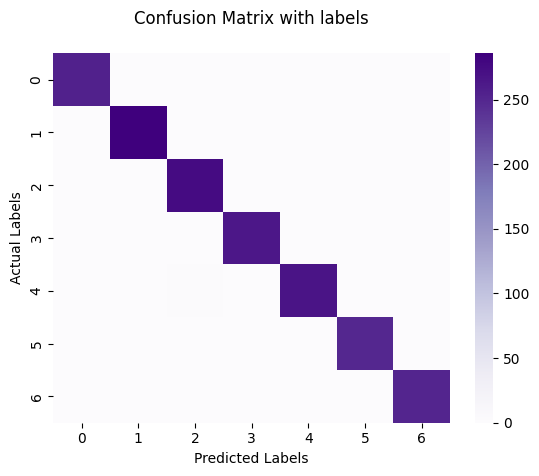

In [19]:
# plotting the confusion matrix for the model label prediction
ax = sns.heatmap(confusion_matrix, fmt='', cmap='Purples')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
plt.show()

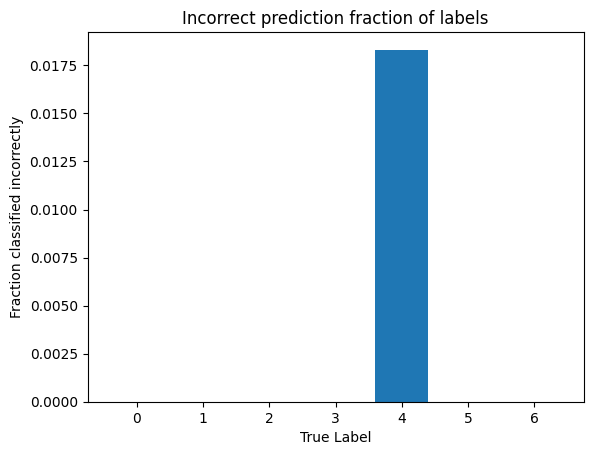

In [20]:
# plotting the incorrect prediction fraction of each class label
label_frac_error = 1 - np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.title('Incorrect prediction fraction of labels')
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.show()